# <center>FRE6351 Time Series Final Project</center>
### <center>Name: Yecheng Cao, Zheyu Gu, Wenjun Wang</center>

# (1) Project Overview
- **Goal:** We use ARMA and ARCH/GARCH to predict ***next daily return and volatility*** respectively, and draw conclusion of prediction power of each method
<br><br>
- **ARMA Methodology:** We use ***historical log return***, which is a stationary time-series, to fit ARMA model. The AR and MA terms are determined by the ***PACF*** and ***ACF*** plots respectively. We then perform ***rolling model fitting and prediction*** on the last 20% of the entire dataset, and the performance is mainly evaluated by comparing ***RMSE and standard deviation*** of log returns and prices
<br><br>
- **ARCH/GARCH Methodology:** ***Different orders*** of ARCH and GARCH models are compared with ***15-day historical volatility estimate model***. Considerations of orders include the ***most basic models*** (ARCH[1] and GARCH[1,1]), the one from ***log return*** ACF and PACF, and the one from ***log return squared*** ACF and PACF. We perform ***recursive forecasting***, and the evaluation is based on ***total log likelihood***

# (2) Import Libraries

In [40]:
#Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm

# (3) Load Data & Raw Data Visualization

In [41]:
df = pd.read_csv('natural_gas_prices_chart.csv',index_col='date')
df['last_value'] = df['value'].shift(1)
df = df.dropna()
df['log_ret'] = np.log(df['value']/df['last_value'])
df['log_ret(%)'] = 100*df['log_ret']

In [42]:
df

,value,last_value,log_ret,log_ret(%)
date,,,,
2007/10/12,6.46,6.85,-0.058619,-5.861933
2007/10/15,7.09,6.46,0.093056,9.305602
2007/10/16,7.29,7.09,0.027818,2.781821
2007/10/17,7.12,7.29,-0.023596,-2.359582
2007/10/18,7.11,7.12,-0.001405,-0.140548
...,...,...,...,...
2020/9/30,1.66,1.74,-0.047068,-4.706751
2020/10/1,1.60,1.66,-0.036814,-3.681397
2020/10/2,1.41,1.60,-0.126414,-12.641392


Text(0.5, 1.0, 'Log Return Series')

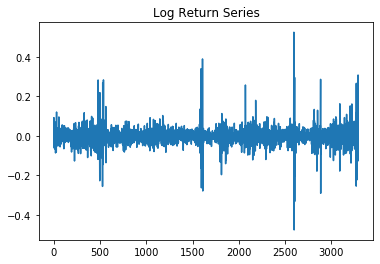

In [43]:
plt.plot(df['log_ret'].values)
plt.title('Log Return Series')

Log return graph shows no significant trend and seasonality, and we can also see the clustering of volatility

Text(0.5, 1.0, 'Log Return Histogram')

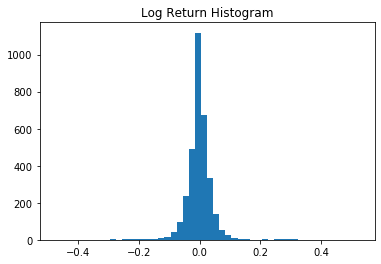

In [44]:
plt.hist(df['log_ret'],bins=50)
plt.title('Log Return Histogram')

Log return distribution is normal-shape, matching the theory that the return is log-normal distributed, and this validation allows more convenient computation of likelihood of volatility estimate

# (4) Augmented Dickey-Fuller Test

In [45]:
# Check for stationarity
def adf_test(data_set, maxlag=None):
    if type(data_set)==pd.core.frame.DataFrame:
        data_set = data_set.dropna().to_numpy().flatten()
    
    result = adfuller(data_set, maxlag=maxlag, autolag=None)
    
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    
    print('Augmented Dickey-Fuller Test:') 
    
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.") 
    else:
        print("Weak evidence against null hypothesis. Time series is non-stationary.")

In [46]:
adf_test(df['log_ret'],maxlag=4)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -32.049727762810356
p-value : 0.0
#Lags Used : 4
Number of Observations Used : 3287
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


With very extreme test statistics and low p-value, it is significant that log return series is stationary

# (5) ACF, PACF, and ARMA Model Fitting on All Data

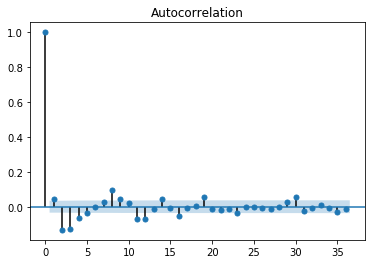

In [47]:
plot_acf(df['log_ret'])
plt.show()

2-step and 3-step lag return are the ones most correlated to the current return, but the correlation levels are still not high

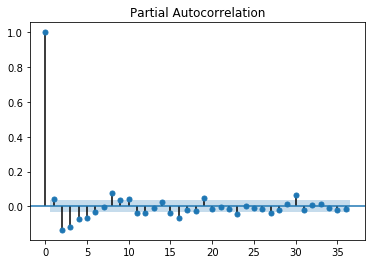

In [48]:
plot_pacf(df['log_ret'])
plt.show()

2-step and 3-step lag return are the ones most partially correlated to the current return, but the partial correlation levels are still not high

In [49]:
model = ARMA(df['log_ret'], order=(3,4)).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                log_ret   No. Observations:                 3292
Model:                     ARMA(3, 4)   Log Likelihood                5698.501
Method:                       css-mle   S.D. of innovations              0.043
Date:                Tue, 20 Oct 2020   AIC                         -11379.003
Time:                        17:16:31   BIC                         -11324.109
Sample:                             0   HQIC                        -11359.351
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.000     -0.932      0.351      -0.001       0.000
ar.L1.log_ret     2.3724      0.047     50.661      0.000       2.281       2.464
ar.L2.log_ret    -2.1451      0.080    -

- ARMA result table shows that coefficients for AR and MA terms are all significant
- Model with order=(5,4) cannot be fitted because coefficient of AR.4 term cannot converge (not stationary), so the best available order=(3,4) has been chosen

Text(0.5, 1.0, 'All Data Residuals Series')

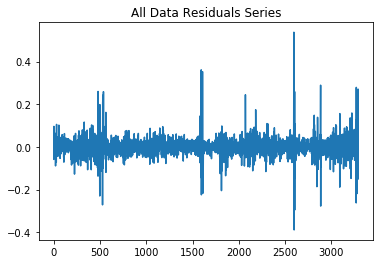

In [50]:
plt.plot(model.resid.values)
plt.title('All Data Residuals Series')

Residuals show no clear pattern, meaning that a linear model is appropriate for the data

Text(0.5, 1.0, 'All Data Residuals Histogram')

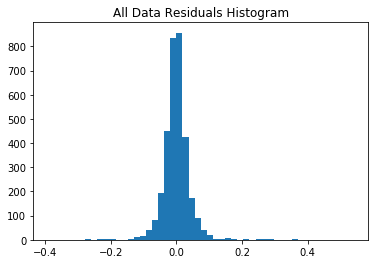

In [51]:
plt.hist(model.resid.values,bins=50)
plt.title('All Data Residuals Histogram')

Residuals are close to normal shape，further indicating the appropriateness of linear model

# (6) Rolling ARMA Model Fitting and Prediction on Test Data

In [52]:
#perform rolling model fitting and one-step-ahead prediction for last 650 data
pred = np.zeros(len(df))
for i in reversed(range(1,651)):
    train = df[:-i]
    model = ARMA(train['log_ret'], order=(3,3)).fit()
    pred[-i] = model.forecast()[0]

ARMA(3,3) model has been chosen as MA.4 term cannot converge(not stationary) in some sample training sets

In [53]:
# extract test set from all data
df['pred_log_ret'] = pred
test = df[-650:]

In [54]:
test['resid'] = test['log_ret']-test['pred_log_ret']
test['error pct'] = abs(test['resid'])/test['log_ret']
test['same sign'] = (test.log_ret * test.pred_log_ret > 0)

In [55]:
test

,value,last_value,log_ret,log_ret(%),pred_log_ret,resid,error pct,same sign
date,,,,,,,,
2018/3/12,2.78,2.71,0.025502,2.550229,-0.005891,0.031393,1.230998,False
2018/3/13,2.76,2.78,-0.007220,-0.722025,0.005562,-0.012782,-1.770347,False
2018/3/14,2.69,2.76,-0.025689,-2.568949,-0.002247,-0.023443,-0.912551,True
2018/3/15,2.70,2.69,0.003711,0.371058,0.000993,0.002718,0.732510,True
2018/3/16,2.62,2.70,-0.030077,-3.007746,0.005992,-0.036069,-1.199220,False
...,...,...,...,...,...,...,...,...
2020/9/30,1.66,1.74,-0.047068,-4.706751,-0.028604,-0.018463,-0.392277,True
2020/10/1,1.60,1.66,-0.036814,-3.681397,-0.003955,-0.032859,-0.892572,True
2020/10/2,1.41,1.60,-0.126414,-12.641392,0.017704,-0.144118,-1.140052,False


“resid” measures the difference between true log return and predicted log return; "error pct" measures the "resid" in proportion of the true log return; "same sign" is assigned True if true and predicted log returns have the same sign

# (7) ARMA Model Performance Evaluation on Log Return and Price

In [56]:
print('Log Return RMSE:',np.sqrt(mean_squared_error(test.log_ret,test.pred_log_ret)))
print('Standard Deviation of Log Return:',test.log_ret.std())

Log Return RMSE: 0.04869170491449176
Standard Deviation of Log Return: 0.04821334825826508


Log return prediction power given by ARMA is similar to the one given by mean value, which is close to 0 

In [57]:
print('Directional accuracy:',test['same sign'].sum()/len(test))

Directional accuracy: 0.46923076923076923


Up/down side prediction accuracy is a bit worse than the random guess

Text(0.5, 1.0, 'Test Data Residuals Series')

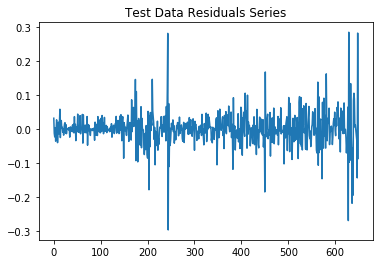

In [58]:
plt.plot(test.resid.values)
plt.title('Test Data Residuals Series')

Residuals of test set prediction also show no clear pattern

Text(0.5, 1.0, 'Test Data Residuals Histogram')

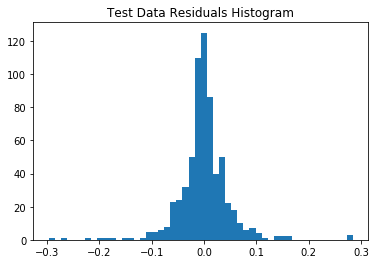

In [59]:
plt.hist(test.resid.values,bins=50)
plt.title('Test Data Residuals Histogram')

Residuals of test set prediction are also close to normal distribution

In [60]:
#transform return prediction to price
test['pred_log_price'] = test.value.shift(1)*np.exp(test.pred_log_ret)
test

,value,last_value,log_ret,log_ret(%),pred_log_ret,resid,error pct,same sign,pred_log_price
date,,,,,,,,,
2018/3/12,2.78,2.71,0.025502,2.550229,-0.005891,0.031393,1.230998,False,NaN
2018/3/13,2.76,2.78,-0.007220,-0.722025,0.005562,-0.012782,-1.770347,False,2.795506
2018/3/14,2.69,2.76,-0.025689,-2.568949,-0.002247,-0.023443,-0.912551,True,2.753807
2018/3/15,2.70,2.69,0.003711,0.371058,0.000993,0.002718,0.732510,True,2.692671
2018/3/16,2.62,2.70,-0.030077,-3.007746,0.005992,-0.036069,-1.199220,False,2.716227
...,...,...,...,...,...,...,...,...,...
2020/9/30,1.66,1.74,-0.047068,-4.706751,-0.028604,-0.018463,-0.392277,True,1.690934
2020/10/1,1.60,1.66,-0.036814,-3.681397,-0.003955,-0.032859,-0.892572,True,1.653448
2020/10/2,1.41,1.60,-0.126414,-12.641392,0.017704,-0.144118,-1.140052,False,1.628579


In [61]:
print("Price RMSE:",np.sqrt(mean_squared_error(test.value.values[1:],test.pred_log_price.values[1:])))
print("Standard Deviation of Price:",test.value.std())

Price RMSE: 0.1250937856968495
Standard Deviation of Price: 0.6243414867257627


Log price prediction power given by ARMA is significantly greater than the one given by mean value, because the ARMA predicted value is based on adjustment of previous price data while mean price prediction has no adjustment

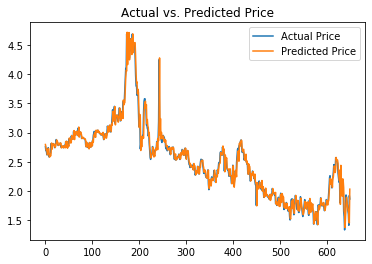

In [62]:
plt.plot(test.value.values[1:],label='Actual Price')
plt.plot(test.pred_log_price.values[1:],label='Predicted Price')
plt.legend()
plt.title('Actual vs. Predicted Price')
plt.show()

**Conclusion:** Even though the predicted price path nicely follows the actual price path, from the analysis above, we can tell ***ARMA model is not good at predicting returns***. Overall speaking, the prediction power of using ARMA and direcctly using the 1-step lag value should be similar

# (8) 15-Day Historical Rolling Window Volatility Forecasting

In [63]:
df['hist_pred_vol'] = df['log_ret'].rolling(window=15).std()
df['hist_pred_vol'] = df['hist_pred_vol'].shift(1)

In [64]:
df

,value,last_value,log_ret,log_ret(%),pred_log_ret,hist_pred_vol
date,,,,,,
2007/10/12,6.46,6.85,-0.058619,-5.861933,0.000000,NaN
2007/10/15,7.09,6.46,0.093056,9.305602,0.000000,NaN
2007/10/16,7.29,7.09,0.027818,2.781821,0.000000,NaN
2007/10/17,7.12,7.29,-0.023596,-2.359582,0.000000,NaN
2007/10/18,7.11,7.12,-0.001405,-0.140548,0.000000,NaN
...,...,...,...,...,...,...
2020/9/30,1.66,1.74,-0.047068,-4.706751,-0.028604,0.105958
2020/10/1,1.60,1.66,-0.036814,-3.681397,-0.003955,0.105621
2020/10/2,1.41,1.60,-0.126414,-12.641392,0.017704,0.105621


15-day historical rolling window volatility forecasting is based on the standard deviation of past 15 days' log returns

# (9) ARCH(3) and GARCH(3,10) in Volatility Forecasting

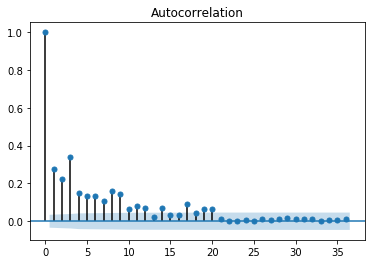

In [65]:
#ACF plot for log return squared
plot_acf(df['log_ret']**2)
plt.show()

The autocorrelation function of log return squared is significant until the 10th lag

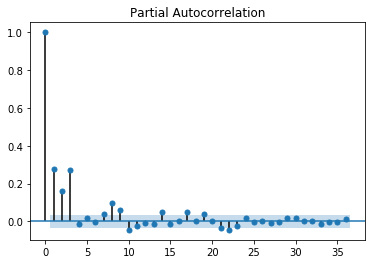

In [66]:
#PACF plot for log return squared
plot_pacf(df['log_ret']**2)
plt.show()

The partial autocorrelation function of log return squared is significant until the 3rd lag

In [67]:
#ARCH(3) Model
arch_1 = np.zeros(len(df))
model = arch_model(df['log_ret(%)'], mean='Zero', vol='ARCH', p=3)
for i in range(3,len(df)):
    end = i
    model_fit = model.fit(last_obs=end,disp='off')
    yhat = model_fit.forecast(horizon=1)
    arch_1[i] = yhat.variance.iloc[i-1,0]
df['ARCH(3)_pred_vol'] = np.sqrt(arch_1)/100

In [68]:
#GARCH(3,10) Model
garch_1 = np.zeros(len(df))
model = arch_model(df['log_ret(%)'], mean='Zero', vol='GARCH', p=3, q=10)
for i in range(10,len(df)):
    end = i
    model_fit = model.fit(last_obs=end,disp='off')
    yhat = model_fit.forecast(horizon=1)
    garch_1[i] = yhat.variance.iloc[i-1,0]
df['GARCH(3,10)_pred_vol'] = np.sqrt(garch_1)/100

In [69]:
df

,value,last_value,log_ret,log_ret(%),pred_log_ret,hist_pred_vol,ARCH(3)_pred_vol,"GARCH(3,10)_pred_vol"
date,,,,,,,,
2007/10/12,6.46,6.85,-0.058619,-5.861933,0.000000,NaN,0.000000,0.000000
2007/10/15,7.09,6.46,0.093056,9.305602,0.000000,NaN,0.000000,0.000000
2007/10/16,7.29,7.09,0.027818,2.781821,0.000000,NaN,0.000000,0.000000
2007/10/17,7.12,7.29,-0.023596,-2.359582,0.000000,NaN,0.093056,0.000000
2007/10/18,7.11,7.12,-0.001405,-0.140548,0.000000,NaN,0.063256,0.000000
...,...,...,...,...,...,...,...,...
2020/9/30,1.66,1.74,-0.047068,-4.706751,-0.028604,0.105958,0.040342,0.097278
2020/10/1,1.60,1.66,-0.036814,-3.681397,-0.003955,0.105621,0.044795,0.089784
2020/10/2,1.41,1.60,-0.126414,-12.641392,0.017704,0.105621,0.044052,0.083388


**Note:** "log_ret(%)" is used to fit models to address the coefficient convergence issue of GARCH model, and the predicted volatility is then re-scaled back to values in decimal format for comparison with "hist_pred_vol"

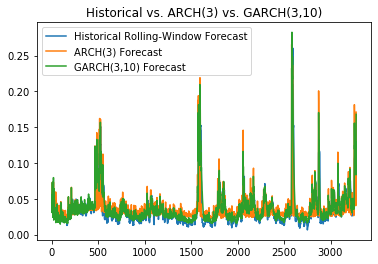

In [70]:
plt.plot(df['hist_pred_vol'].values[15:],label='Historical Rolling-Window Forecast')
plt.plot(df['ARCH(3)_pred_vol'].values[15:],label='ARCH(3) Forecast')
plt.plot(df['GARCH(3,10)_pred_vol'].values[15:],label='GARCH(3,10) Forecast')
plt.legend()
plt.title("Historical vs. ARCH(3) vs. GARCH(3,10)")
plt.show()

All 3 estimated volatilities show similar paths, and a more rigorous metric need to be used for performance  evaluation. As true volatility cannot be directly observed given our data frequency, we need to calculate likelihood of each estimate for performance evaluation

In [71]:
#Compute likelihood and log-likelihood of predictions on each trading day
df["hist_pred_vol likelihood"] = norm.pdf(df["log_ret"],loc=0,scale=df["hist_pred_vol"])
df["hist_pred_vol log-likelihood"] = np.log(df["hist_pred_vol likelihood"])
df["ARCH(3)_pred_vol likelihood"] = norm.pdf(df["log_ret"],loc=0,scale=df["ARCH(3)_pred_vol"])
df["ARCH(3)_pred_vol log-likelihood"] = np.log(df["ARCH(3)_pred_vol likelihood"])
df["GARCH(3,10)_pred_vol likelihood"] = norm.pdf(df["log_ret"],loc=0,scale=df["GARCH(3,10)_pred_vol"])
df["GARCH(3,10)_pred_vol log-likelihood"] = np.log(df["GARCH(3,10)_pred_vol likelihood"])

The likelihood of each estimate on any given day is just the log return's probability density function of a normal distribution centered at 0 with standard deviation equal to the estimated volatility. It measures how "likely" the log return can happen under the estimated distribution. The 0 mean assumption is just a simple approximation of the real mean, which is very close to 0

In [100]:
#Compute models' joint log-likelihood
print("Total historical log-likelihood: ",df["hist_pred_vol log-likelihood"][15:].sum())
print("Total ARCH(3) log-likelihood: ",df["ARCH(3)_pred_vol log-likelihood"][15:].sum())
print("Total GARCH(3,10) log-likelihood: ", df["GARCH(3,10)_pred_vol log-likelihood"][15:].sum())

Total historical log-likelihood:  6278.757673557446
Total ARCH(3) log-likelihood:  6248.658826263347
Total GARCH(3,10) log-likelihood:  6401.424980037511


The total log-likelihood of all estimated data points is calculated for each method. The reason why we use log-likelihood instead of likelihood is that we can transform the multiplication computation to the addition computation of each individual likelihood, which efficiently avoids resulting to a very large number, even potentially causing overflow

In [73]:
#Model Performance Comparison
print("Log-likelihood of ARCH(3) is {:.2}% higher than that of historical model".format((df["ARCH(3)_pred_vol log-likelihood"][15:].sum()/df["hist_pred_vol log-likelihood"][15:].sum()-1)*100))
print("Log-likelihood of GARCH(3,10) is {:.2}% higher than that of historical model".format((df["GARCH(3,10)_pred_vol log-likelihood"][15:].sum()/df["hist_pred_vol log-likelihood"][15:].sum()-1)*100))

Log-likelihood of ARCH(3) is -0.48% higher than that of historical model
Log-likelihood of GARCH(3,10) is 2.0% higher than that of historical model


Higher log-likelihood generally means the model is more accurate

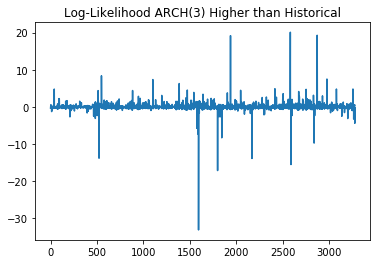

In [74]:
plt.plot(df['ARCH(3)_pred_vol log-likelihood'][15:].values-df['hist_pred_vol log-likelihood'][15:].values)
plt.title("Log-Likelihood ARCH(3) Higher than Historical")
plt.show()

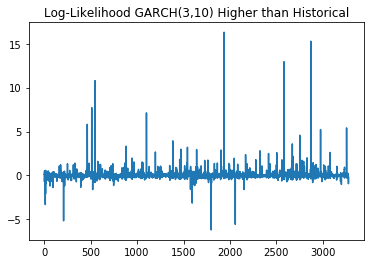

In [75]:
plt.plot(df['GARCH(3,10)_pred_vol log-likelihood'][15:].values-df['hist_pred_vol log-likelihood'][15:].values)
plt.title("Log-Likelihood GARCH(3,10) Higher than Historical")
plt.show()

**Conclusion:** GARCH(3,10) model outperforms the historical volatility model by 2% in log-likelihood, while ARCH(3) model underperforms the historical volatility model by 0.48% in log-likelihood. By straightly eyeballing the graph above, we can also notice the superiority of GARCH(3,10) as GARCH's prediction is better than historical model's prediction in most days.

# (10) ARCH(4) and GARCH(4,4) in Volatility Forecasting

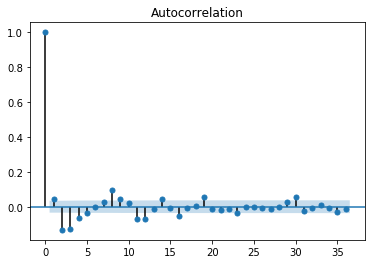

In [76]:
#ACF plot for log return
plot_acf(df['log_ret'])
plt.show()

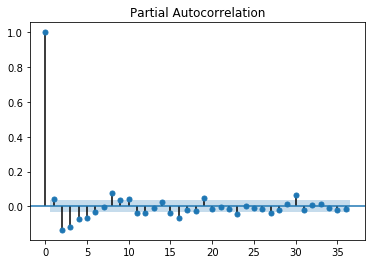

In [77]:
#PACF plot for log return
plot_pacf(df['log_ret'])
plt.show()

In [78]:
#ARCH(4) Model
arch_1 = np.zeros(len(df))
model = arch_model(df['log_ret(%)'], mean='Zero', vol='ARCH', p=4)
for i in range(4,len(df)):
    end = i
    model_fit = model.fit(last_obs=end,disp='off')
    yhat = model_fit.forecast(horizon=1)
    arch_1[i] = yhat.variance.iloc[i-1,0]
df['ARCH(4)_pred_vol'] = np.sqrt(arch_1)/100

In [79]:
#GARCH(4,4) Model
garch_1 = np.zeros(len(df))
model = arch_model(df['log_ret(%)'], mean='Zero', vol='GARCH', p=4, q=4)
for i in range(4,len(df)):
    end = i
    model_fit = model.fit(last_obs=end,disp='off')
    yhat = model_fit.forecast(horizon=1)
    garch_1[i] = yhat.variance.iloc[i-1,0]
df['GARCH(4,4)_pred_vol'] = np.sqrt(garch_1)/100

In [80]:
df

,value,last_value,log_ret,log_ret(%),pred_log_ret,hist_pred_vol,ARCH(3)_pred_vol,"GARCH(3,10)_pred_vol",hist_pred_vol likelihood,hist_pred_vol log-likelihood,ARCH(3)_pred_vol likelihood,ARCH(3)_pred_vol log-likelihood,"GARCH(3,10)_pred_vol likelihood","GARCH(3,10)_pred_vol log-likelihood",ARCH(4)_pred_vol,"GARCH(4,4)_pred_vol"
date,,,,,,,,,,,,,,,,
2007/10/12,6.46,6.85,-0.058619,-5.861933,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2007/10/15,7.09,6.46,0.093056,9.305602,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2007/10/16,7.29,7.09,0.027818,2.781821,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2007/10/17,7.12,7.29,-0.023596,-2.359582,0.000000,NaN,0.093056,0.000000,NaN,NaN,4.151490,1.423467,NaN,NaN,0.000000,0.000000
2007/10/18,7.11,7.12,-0.001405,-0.140548,0.000000,NaN,0.063256,0.000000,NaN,NaN,6.305218,1.841378,NaN,NaN,0.063247,0.038264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020/9/30,1.66,1.74,-0.047068,-4.706751,-0.028604,0.105958,0.040342,0.097278,3.411375,1.227116,5.006902,1.610817,3.648033,1.294188,0.059968,0.101287
2020/10/1,1.60,1.66,-0.036814,-3.681397,-0.003955,0.105621,0.044795,0.089784,3.554495,1.268213,6.353554,1.849014,4.085106,1.407348,0.040872,0.090633
2020/10/2,1.41,1.60,-0.126414,-12.641392,0.017704,0.105621,0.044052,0.083388,1.845439,0.612717,0.147481,-1.914058,1.516232,0.416228,0.042611,0.081664


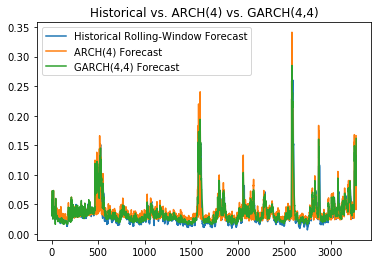

In [103]:
plt.plot(df['hist_pred_vol'].values[15:],label='Historical Rolling-Window Forecast')
plt.plot(df['ARCH(4)_pred_vol'].values[15:],label='ARCH(4) Forecast')
plt.plot(df['GARCH(4,4)_pred_vol'].values[15:],label='GARCH(4,4) Forecast')
plt.legend()
plt.title("Historical vs. ARCH(4) vs. GARCH(4,4)")
plt.show()

In [82]:
#Compute likelihood and log-likelihood of predictions on each trading day
df["ARCH(4)_pred_vol likelihood"] = norm.pdf(df["log_ret"],loc=0,scale=df["ARCH(4)_pred_vol"])
df["ARCH(4)_pred_vol log-likelihood"] = np.log(df["ARCH(4)_pred_vol likelihood"])
df["GARCH(4,4)_pred_vol likelihood"] = norm.pdf(df["log_ret"],loc=0,scale=df["GARCH(4,4)_pred_vol"])
df["GARCH(4,4)_pred_vol log-likelihood"] = np.log(df["GARCH(4,4)_pred_vol likelihood"])

In [101]:
#Compute models' joint log-likelihood
print("Total historical log-likelihood: ",df["hist_pred_vol log-likelihood"][15:].sum())
print("Total ARCH(4) log-likelihood: ",df["ARCH(4)_pred_vol log-likelihood"][15:].sum())
print("Total GARCH(4,4) log-likelihood: ", df["GARCH(4,4)_pred_vol log-likelihood"][15:].sum())

Total historical log-likelihood:  6278.757673557446
Total ARCH(4) log-likelihood:  6338.600532366385
Total GARCH(4,4) log-likelihood:  6398.387027598104


In [84]:
#Model Performance Comparison
print("Log-likelihood of ARCH(4) is {:.2}% higher than that of historical model".format((df["ARCH(4)_pred_vol log-likelihood"][15:].sum()/df["hist_pred_vol log-likelihood"][15:].sum()-1)*100))
print("Log-likelihood of GARCH(4,4) is {:.2}% higher than that of historical model".format((df["GARCH(4,4)_pred_vol log-likelihood"][15:].sum()/df["hist_pred_vol log-likelihood"][15:].sum()-1)*100))

Log-likelihood of ARCH(4) is 0.95% higher than that of historical model
Log-likelihood of GARCH(4,4) is 1.9% higher than that of historical model


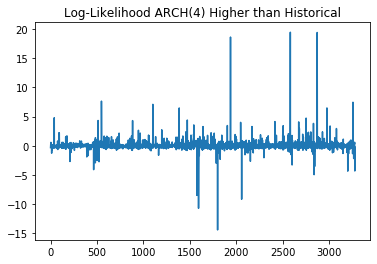

In [85]:
plt.plot(df['ARCH(4)_pred_vol log-likelihood'][15:].values-df['hist_pred_vol log-likelihood'][15:].values)
plt.title("Log-Likelihood ARCH(4) Higher than Historical")
plt.show()

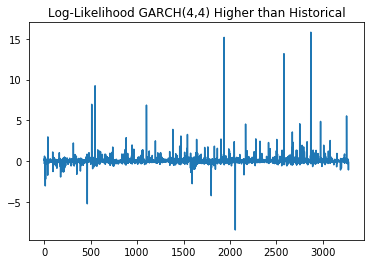

In [86]:
plt.plot(df['GARCH(4,4)_pred_vol log-likelihood'][15:].values-df['hist_pred_vol log-likelihood'][15:].values)
plt.title("Log-Likelihood GARCH(4,4) Higher than Historical")
plt.show()

**Conclusion:** ARCH(4) model outperforms the historical volatility model by 0.95% in log-likelihood and GARCH(4,4) model beats the historical volatility model by 1.9% in log-likelihood. By comparing the graphs above, we could observe that the shape of ARCH(4) and GARCH(4,4) is pretty similar, while GARCH(4,4) performs better by not making extremely bad predictions.

# (11) ARCH(1) and GARCH(1,1) in Volatility Forecasting

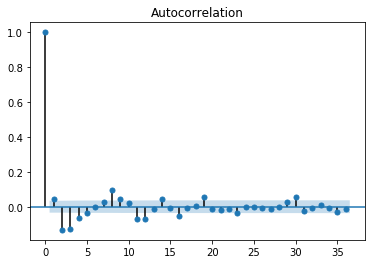

In [87]:
#ACF plot for log return
plot_acf(df['log_ret'])
plt.show()

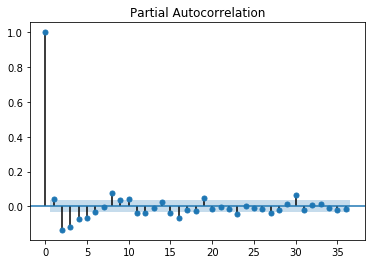

In [88]:
#PACF plot for log return
plot_pacf(df['log_ret'])
plt.show()

In [89]:
#ARCH(1) Model
arch_1 = np.zeros(len(df))
model = arch_model(df['log_ret(%)'], mean='Zero', vol='ARCH', p=1)
for i in range(1,len(df)):
    end = i
    model_fit = model.fit(last_obs=end,disp='off')
    yhat = model_fit.forecast(horizon=1)
    arch_1[i] = yhat.variance.iloc[i-1,0]
df['ARCH(1)_pred_vol'] = np.sqrt(arch_1)/100

In [90]:
#GARCH(1,1) Model
garch_1 = np.zeros(len(df))
model = arch_model(df['log_ret(%)'], mean='Zero', vol='GARCH', p=1, q=1)
for i in range(1,len(df)):
    end = i
    model_fit = model.fit(last_obs=end,disp='off')
    yhat = model_fit.forecast(horizon=1)
    garch_1[i] = yhat.variance.iloc[i-1,0]
df['GARCH(1,1)_pred_vol'] = np.sqrt(garch_1)/100

In [91]:
df

,value,last_value,log_ret,log_ret(%),pred_log_ret,hist_pred_vol,ARCH(3)_pred_vol,"GARCH(3,10)_pred_vol",hist_pred_vol likelihood,hist_pred_vol log-likelihood,...,"GARCH(3,10)_pred_vol likelihood","GARCH(3,10)_pred_vol log-likelihood",ARCH(4)_pred_vol,"GARCH(4,4)_pred_vol",ARCH(4)_pred_vol likelihood,ARCH(4)_pred_vol log-likelihood,"GARCH(4,4)_pred_vol likelihood","GARCH(4,4)_pred_vol log-likelihood",ARCH(1)_pred_vol,"GARCH(1,1)_pred_vol"
date,,,,,,,,,,,,,,,,,,,,,
2007/10/12,6.46,6.85,-0.058619,-5.861933,0.000000,NaN,0.000000,0.000000,NaN,NaN,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
2007/10/15,7.09,6.46,0.093056,9.305602,0.000000,NaN,0.000000,0.000000,NaN,NaN,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.058604,0.058619
2007/10/16,7.29,7.09,0.027818,2.781821,0.000000,NaN,0.000000,0.000000,NaN,NaN,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.077766,0.082689
2007/10/17,7.12,7.29,-0.023596,-2.359582,0.000000,NaN,0.093056,0.000000,NaN,NaN,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.065496,0.062862
2007/10/18,7.11,7.12,-0.001405,-0.140548,0.000000,NaN,0.063256,0.000000,NaN,NaN,...,NaN,NaN,0.063247,0.038264,6.306103,1.841518,10.418961,2.343627,0.023596,0.040885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020/9/30,1.66,1.74,-0.047068,-4.706751,-0.028604,0.105958,0.040342,0.097278,3.411375,1.227116,...,3.648033,1.294188,0.059968,0.101287,4.889008,1.586989,3.535627,1.262891,0.044897,0.097044
2020/10/1,1.60,1.66,-0.036814,-3.681397,-0.003955,0.105621,0.044795,0.089784,3.554495,1.268213,...,4.085106,1.407348,0.040872,0.090633,6.506025,1.872729,4.053188,1.399504,0.043550,0.089916
2020/10/2,1.41,1.60,-0.126414,-12.641392,0.017704,0.105621,0.044052,0.083388,1.845439,0.612717,...,1.516232,0.416228,0.042611,0.081664,0.114876,-2.163903,1.474153,0.388084,0.039796,0.082723


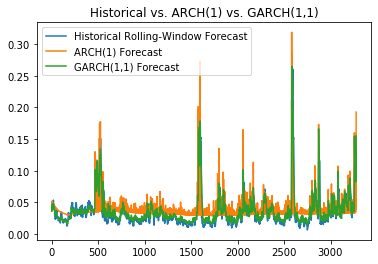

In [104]:
plt.plot(df['hist_pred_vol'].values[15:],label='Historical Rolling-Window Forecast')
plt.plot(df['ARCH(1)_pred_vol'].values[15:],label='ARCH(1) Forecast')
plt.plot(df['GARCH(1,1)_pred_vol'].values[15:],label='GARCH(1,1) Forecast')
plt.legend()
plt.title("Historical vs. ARCH(1) vs. GARCH(1,1)")
plt.show()

In [93]:
#Compute likelihood and log-likelihood of predictions on each trading day
df["ARCH(1)_pred_vol likelihood"] = norm.pdf(df["log_ret"],loc=0,scale=df["ARCH(1)_pred_vol"])
df["ARCH(1)_pred_vol log-likelihood"] = np.log(df["ARCH(1)_pred_vol likelihood"])
df["GARCH(1,1)_pred_vol likelihood"] = norm.pdf(df["log_ret"],loc=0,scale=df["GARCH(1,1)_pred_vol"])
df["GARCH(1,1)_pred_vol log-likelihood"] = np.log(df["GARCH(1,1)_pred_vol likelihood"])

In [102]:
#Compute models' joint log-likelihood
print("Total historical log-likelihood: ",df["hist_pred_vol log-likelihood"][15:].sum())
print("Total ARCH(1) log-likelihood: ",df["ARCH(1)_pred_vol log-likelihood"][15:].sum())
print("Total GARCH(1,1) log-likelihood: ", df["GARCH(1,1)_pred_vol log-likelihood"][15:].sum())

Total historical log-likelihood:  6278.757673557446
Total ARCH(1) log-likelihood:  6046.779742834229
Total GARCH(1,1) log-likelihood:  6427.531165755998


In [95]:
#Model Performance Comparison
print("Log-likelihood of ARCH(1) is {:.2}% higher than that of historical model".format((df["ARCH(1)_pred_vol log-likelihood"][15:].sum()/df["hist_pred_vol log-likelihood"][15:].sum()-1)*100))
print("Log-likelihood of GARCH(1,1) is {:.2}% higher than that of historical model".format((df["GARCH(1,1)_pred_vol log-likelihood"][15:].sum()/df["hist_pred_vol log-likelihood"][15:].sum()-1)*100))


Log-likelihood of ARCH(1) is -3.7% higher than that of historical model
Log-likelihood of GARCH(1,1) is 2.4% higher than that of historical model


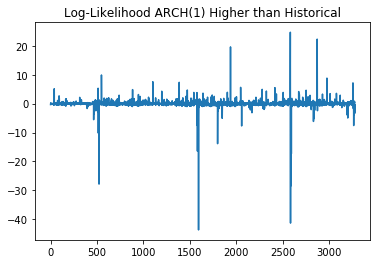

In [96]:
plt.plot(df['ARCH(1)_pred_vol log-likelihood'][15:].values-df['hist_pred_vol log-likelihood'][15:].values)
plt.title("Log-Likelihood ARCH(1) Higher than Historical")
plt.show()

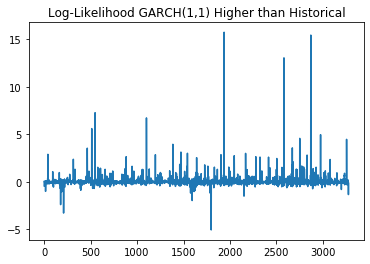

In [97]:
plt.plot(df['GARCH(1,1)_pred_vol log-likelihood'][15:].values-df['hist_pred_vol log-likelihood'][15:].values)
plt.title("Log-Likelihood GARCH(1,1) Higher than Historical")
plt.show()

**Conclusion:** GARCH(1,1) model beats the historical volatility model by 2.4% in log-likelihood, while ARCH(1) model underperforms the historical volatility model by 3.7% in log-likelihood. By directly looking at the graphs above, we could recognize that GARCH(1,1) performs outstandingly at most days, but ARCH(1) makes very bad predictions for the volatilities that linked to the day before.

# (12) Volatility Forecasting Summary

In [98]:
df_vol=pd.DataFrame({"ARCH":["{:.2}%".format((df["ARCH(3)_pred_vol log-likelihood"][15:].sum()/df["hist_pred_vol log-likelihood"][15:].sum()-1)*100),
                         "{:.2}%".format((df["ARCH(4)_pred_vol log-likelihood"][15:].sum()/df["hist_pred_vol log-likelihood"][15:].sum()-1)*100),
                         "{:.2}%".format((df["ARCH(1)_pred_vol log-likelihood"][15:].sum()/df["hist_pred_vol log-likelihood"][15:].sum()-1)*100)
                        ], 
                     "GARCH":["{:.2}%".format((df["GARCH(3,10)_pred_vol log-likelihood"][15:].sum()/df["hist_pred_vol log-likelihood"][15:].sum()-1)*100),
                          "{:.2}%".format((df["GARCH(4,4)_pred_vol log-likelihood"][15:].sum()/df["hist_pred_vol log-likelihood"][15:].sum()-1)*100),
                          "{:.2}%".format((df["GARCH(1,1)_pred_vol log-likelihood"][15:].sum()/df["hist_pred_vol log-likelihood"][15:].sum()-1)*100)
                        ]
                    })
df_vol.index = ['ARCH(3)/GARCH(3,10)', 'ARCH(4)/GARCH(4,4)', 'ARCH(1)/GARCH(1,1)'] 
df_vol

,ARCH,GARCH
"ARCH(3)/GARCH(3,10)",-0.48%,2.0%
"ARCH(4)/GARCH(4,4)",0.95%,1.9%
"ARCH(1)/GARCH(1,1)",-3.7%,2.4%


**Conclusion:** GARCH models performs better than ARCH models in general, which indicates that past volatilities do have effects on predicting future volatilities. GARCH(1,1) model performs best out of 6 models, and beats the historical volatility model by 2.4% in log-likelihood.

# (13) Project Main Conclusions
- It is hardly feasible for ARMA to predict returns or prices of commodities due to lack of correlation with past values, and the ARMA prediction is not significantly different than the one simply given by the previous value
<br><br>
- ARCH with certain orders can outperform the 15-day historical volatility forecasting model, but it is not a general case for other orders
<br><br>
- GARCH with different orders are all having more accurate volatility forecasting than the 15-day historical volatility forecasting model and the ARCH models. Even though the GARCH model with orders determined from ACF and PACF is good, but the most basic GARCH(1,1) model is the best among the all, matching the empirical evidence discovered by practitioners